In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from datetime import datetime
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time
from torch.optim import lr_scheduler
import os
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from pathlib import Path
print(torch.__version__)
torch.cuda.is_available()

1.5.0


True

In [3]:
LABS_DIR = Path('C:/Labs/')
DATA_DIR = LABS_DIR/'DataDomains'
# DATA_DIR_M = LABS_DIR/'DataDomains'/'Male'
# DATA_DIR_F = LABS_DIR/'DataDomains'/'Female'
# DATA_DIR_U = LABS_DIR/'DataDomains'/'Undecided'

In [4]:
# Data augmentation and normalization for training
# for validatin we use normalization and resize (for train we also change the angle and size of the images)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
#        transforms.RandomResizedCrop(224, scale=(0.96, 1.04), ratio=(0.92, 1.08)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Data Loader

In [5]:
BATCH_SIZE = 16
SAMPLE_SIZE = None 



''' The function takes the data loader and a parameter  '''
def create_train_val_slice(image_datasets,sample_size=None,val_same_as_train=False):
    img_dataset = image_datasets # reminder - this is a *generator* of the dataset
    
    # clone the image_datasets_reduced[train] generator for the val
    if val_same_as_train:
        img_dataset['val'] = list(img_dataset['train'])
        
    dataset_sizes = {x: len(img_dataset[x]) for x in ['train', 'val']}

    if sample_size: # return the whole data set
        sample_n = {x: random.sample(list(range(dataset_sizes[x])), sample_size) for x in ['train', 'val']}
        img_dataset = {x: torch.utils.data.Subset(img_dataset[x], sample_n[x]) for x in ['train', 'val']}
        dataset_sizes = {x: len(img_dataset[x]) for x in ['train', 'val']}
       
    dataloaders = {x: torch.utils.data.DataLoader(img_dataset[x], batch_size=BATCH_SIZE,
                                                      shuffle=True, num_workers=0) for x in ['train', 'val']}
    
    return dataloaders, dataset_sizes


# ''' The function takes the data loader and a parameter  '''
# def create_train_val_slice(image_datasets,sample_size=None,val_same_as_train=False):
#     dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
        
#     if not sample_size: # return the whole data set
#         dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
#                                                       shuffle=True, num_workers=0)
#                       for x in ['train', 'val']}
#         return dataloaders, dataset_sizes
    
#     sample_n = {x: random.sample(list(range(dataset_sizes[x])), sample_size)
#                 for x in ['train', 'val']}

#     image_datasets_reduced = {x: torch.utils.data.Subset(image_datasets[x], sample_n[x])
#                               for x in ['train', 'val']}
    
#     #clone the image_datasets_reduced[train] generator for the val
#     if val_same_as_train:
#         image_datasets_reduced['val'] = list(image_datasets_reduced['train'])
# #         image_datasets_reduced['train'] = image_datasets_reduced['val']
        
#     dataset_sizes = {x: len(image_datasets_reduced[x]) for x in ['train', 'val']}

#     dataloaders_reduced = {x: torch.utils.data.DataLoader(image_datasets_reduced[x], batch_size=BATCH_SIZE,
#                                                   shuffle=True, num_workers=1) for x in ['train', 'val']}
#     return dataloaders_reduced, dataset_sizes


image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

class_names = image_datasets['train'].classes

my_data, dataset_sizes =  create_train_val_slice(image_datasets,sample_size=SAMPLE_SIZE,val_same_as_train=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Classes: ", class_names) 
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

Classes:  ['Female', 'Male']
Train image size: 2486
Validation image size: 2486


In [6]:
def get_model():
    model_conv = torchvision.models.resnet18(pretrained=True)
    #model_conv = torchvision.models.resnet50(pretrained=True)
    #model_conv = torchvision.models.resnet101(pretrained=True)

    num_ftrs = model_conv.fc.in_features #probably the feature exctractor
    #model_conv.fc = nn.Linear(num_ftrs, 1)
    model_conv.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1),
        nn.Sigmoid(),
    )
    
    
    utils.freeze_layers_grad(model_conv)
    
    model_conv = model_conv.to(device)
    return model_conv

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated  

# Show sample of the data for review

classes=tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1])


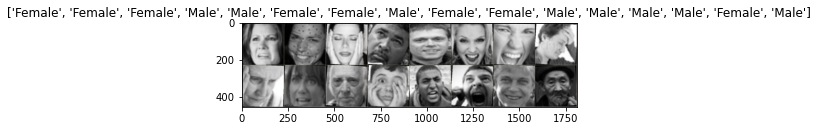

classes=tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])


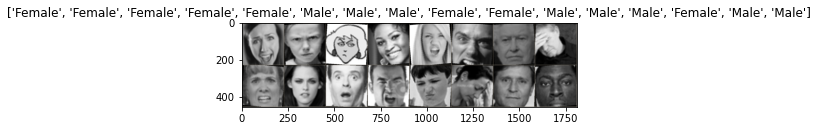

In [8]:
# # Get a batch of training data
inputs, classes = next(iter(my_data['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])


# # Get a batch of validation data
inputs, classes = next(iter(my_data['val']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])

In [9]:
def train_model(data, model, criterion, optimizer, scheduler, num_epochs=2, writer=None):
    since = time.time()

    train_accuracy_history = []
    train_loss_history = []

    test_accuracy_history = []
    test_loss_history = []

    print("Starting epochs")
    for epoch in range(1,num_epochs+1):
        print(f'Epoch: {epoch} of {num_epochs}')
        model.train()  # Set model to training mode
        running_test_loss = 0.0
        running_corrects = 0.0 
        
        for i, (inputs, labels) in enumerate(data['train']):
            # data['train'] contains (input,labels) for every batch (so i=[1...NUM OF BATCHES]
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs).squeeze()
                #_, preds = torch.max(outputs, 1)
                preds = torch.round(outputs)
                loss = criterion(outputs, labels.float())

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

#                 print("Train- Outputs:    ",outputs.tolist())
#                 print("Train- Predictions:",preds.int().tolist())
#                 print("Train- Labels:     ",labels.data.tolist())
#                 print("Train- Loss:     ",loss)
        
            batch_loss = loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            if writer is not None: # save train loss for each batch
                x_axis = 1000*(epoch + i/(dataset_sizes['train']//BATCH_SIZE))
                writer.add_scalar('batch loss',batch_loss/BATCH_SIZE,x_axis)

        if scheduler is not None:
            scheduler.step() #scheduler step is performed per-epoch in the training phase

        train_acc = running_corrects /dataset_sizes['train']
        if writer is not None: # save epoch accuracy
            x_axis = epoch 
            writer.add_scalar('accuracy-train',
                train_acc,
                x_axis)        
        
        epoch_loss, epoch_acc = eval_model(criterion, data, model, optimizer)
        
        if writer is not None: # save epoch accuracy
            x_axis = epoch 
            writer.add_scalar('accuracy-val',
                epoch_acc,
                x_axis)

    # TODO check stop condition by overfit
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #return the last trained model
    return model


def eval_model(criterion, data, model, optimizer):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0.0

    for i, (inputs, labels) in enumerate(data['val']):
        # data['val'] contains (input,labels) for every batch (so i=[1...NUM OF BATCHES]

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs).squeeze()
            #_, preds = torch.max(outputs, 1)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.float())

        # statistics - sum loss and accuracy on all batches
        running_loss += loss.item() * inputs.size(0) #item.loss() is the average loss of the batch
#         print("Eval - Outputs:    ",outputs.tolist())
#         print("Eval - Predictions:",preds.int().tolist())
#         print("Eval - Labels:     ",labels.data.tolist())
        running_corrects += torch.sum(preds == labels.data)
#         print("Eval - Running corrects:",running_corrects)

    epoch_loss = float(running_loss) / dataset_sizes['val']
    print()
    epoch_acc = running_corrects.double() / dataset_sizes['val']
    print(f'Test Loss: {epoch_loss:.4f} Test Acc: {epoch_acc:.4f}')
                
    return epoch_loss, epoch_acc

# Run experiment

In [10]:
NUM_EPOCHS = 30

def run_experiment(data, lr_initial, gamma, step_size, weight_decay, num_of_epochs):
    """
    Gets all hyper parameters and creates the relevant optimizer and scheduler according to those params

    """
    model_net = get_model()
    #criterion = nn.CrossEntropyLoss()  # softmax+log
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model_net.parameters(), lr=lr_initial, weight_decay=weight_decay)

    # decay LR by a factor of gamma every step_size epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # check optimizer and schedular due to ADAM

    experiment_name = datetime.now().strftime("%Y%m%d-%H%M%S") + f'_lr_{lr_initial}_st_{step_size}_gma_{gamma}_wDK_{weight_decay}'
    print("Experiment name: ", experiment_name)

    writer = SummaryWriter('runs/' + experiment_name)
    trained_model = train_model(data,
                                model_net,
                                criterion,
                                optimizer,
                                exp_lr_scheduler,
                                num_epochs=num_of_epochs,
                                writer=writer)
    return trained_model


model_conv = run_experiment(my_data, lr_initial = 0.0005,gamma = 0.3, step_size = 5, weight_decay = 0.1, num_of_epochs = 30)
                
# for lr in [0.0005, 0.0001]:
#     for scheduler_step_size in [5, 7, 9]:
#         for scheduler_gamma in [0.1, 0.3, 0.5]:
#             for weight_decay in [0.01,0.1]:
#                 model_conv = run_experiment(my_data, lr, scheduler_gamma, scheduler_step_size, weight_decay, NUM_EPOCHS)

Experiment name:  20201011-112315_lr_0.0005_st_5_gma_0.3_wDK_0.001
Starting epochs
Epoch: 1 of 30

Test Loss: 0.3915 Test Acc: 0.8258
Epoch: 2 of 30

Test Loss: 0.4099 Test Acc: 0.8254
Epoch: 3 of 30

Test Loss: 0.3661 Test Acc: 0.8331
Epoch: 4 of 30

Test Loss: 0.2552 Test Acc: 0.8890
Epoch: 5 of 30

Test Loss: 0.3278 Test Acc: 0.8608
Epoch: 6 of 30

Test Loss: 0.1412 Test Acc: 0.9541
Epoch: 7 of 30

Test Loss: 0.1009 Test Acc: 0.9690
Epoch: 8 of 30

Test Loss: 0.1068 Test Acc: 0.9598
Epoch: 9 of 30

Test Loss: 0.1114 Test Acc: 0.9602
Epoch: 10 of 30

Test Loss: 0.0854 Test Acc: 0.9718
Epoch: 11 of 30

Test Loss: 0.0421 Test Acc: 0.9924
Epoch: 12 of 30

Test Loss: 0.0251 Test Acc: 0.9952
Epoch: 13 of 30

Test Loss: 0.0223 Test Acc: 0.9960
Epoch: 14 of 30

Test Loss: 0.0159 Test Acc: 0.9980
Epoch: 15 of 30

Test Loss: 0.0091 Test Acc: 0.9996
Epoch: 16 of 30

Test Loss: 0.0085 Test Acc: 0.9996
Epoch: 17 of 30

Test Loss: 0.0065 Test Acc: 1.0000
Epoch: 18 of 30

Test Loss: 0.0062 Test Ac

In [11]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# target output size of 5x7
m = nn.AdaptiveAvgPool2d((5,7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)
# target output size of 7x7 (square)
m = nn.AdaptiveAvgPool2d(7)
input = torch.randn(1, 64, 10, 9)
output = m(input)
# target output size of 10x7
m = nn.AdaptiveMaxPool2d((None, 7))
input = torch.randn(1, 64, 10, 9)
output = m(input)

torch.Size([1, 64, 5, 7])


In [13]:
class TrainingParams:
    def __init__(self, experiment_name, model,  lr_initial, weight_decay,step_size,gamma,num_epochs):
        self.experiment_name = experiment_name
        self.model = model
        self.label_criterion = nn.CrossEntropyLoss()  # softmax+log
        self.domain_criterion = nn.functional.binary_cross_entropy_with_logits # TODO check this loss criterion
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr_initial, weight_decay=weight_decay)
        self.scheduler= lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        self.num_epochs = num_epochs